# Development Notebook for extracting icebergs from DEMs

by Jessica Scheick

In [ ]:
ssh jscheick@pennell.ess.uci.edu
cd /u/pennell-z0/eric/GREENLAND/ArticDEM/KANE_BASIN

In [3]:
# iceberg_identification.py script from Mike Wood - using as a starting point

##########################################################################################
# import the required packages

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

#this is just to ignore an annoying numpy warning on my machine
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%load_ext autoreload
from icebath import bergdf as bdf
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import geopandas as gpd
from shapely.geometry import Point

# d = {'col1': ['name1', 'name2'], 'geometry': [Point(1,2), Point(2,1)]}
# gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")
# gdf

gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [14]:
test = bdf.BergGDF(gdf)

In [18]:
test._obj

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [21]:
test.offcenter()

0      POINT (163.85316 -17.31631)
1        POINT (34.75299 -6.25773)
2       POINT (-12.13783 24.29117)
3       POINT (-98.14238 61.46908)
4      POINT (-112.59944 45.70563)
                  ...             
172      POINT (20.81965 44.23304)
173      POINT (19.28618 42.78904)
174      POINT (20.89536 42.57937)
175     POINT (-61.33037 10.42824)
176       POINT (30.19862 7.29289)
Length: 177, dtype: geometry

In [6]:
##########################################################################################
# create subfunctions to organize script

def read_DEM_grid(demFilePath):

    #demFilePath='/Users/mhwood/Documents/Research/Data Repository/Greenland/DEM/GLISTIN/Strips/Resampled_50m/OMG_GLISTIN_Elevation_16/OMG_GLISTIN_Elevation_16_2019_050.nc'
    #data = xr.open_dataset(demFilePath)
    data = xr.open_rasterio(demFilePath)

    x = np.array(data['x'])
    y = np.array(data['y'])
    elev = np.array(data['elevation'])
    geoid = np.array(data['geoid'])
    elev = elev-geoid


    # limit bounds of example fjord
    minX = 533960.0
    maxX = 547467.0
    minY = 7355000.0
    maxY = 7365332.0

    xIndices = np.logical_and(x>=minX,x<=maxX)
    yIndices = np.logical_and(y>=minY,y<=maxY)

    x = x[xIndices]
    y = y[yIndices]
    elev = elev[:,xIndices]
    elev = elev[yIndices,:]
    maxElev = 100
    elev[elev>maxElev] = maxElev
    minElev = -5
    elev[elev<minElev] = minElev

    #fill in nans with closest neighbor
    X,Y= np.meshgrid(x,y)
    points=np.hstack([np.reshape(X,(np.size(X),1)),
                      np.reshape(Y, (np.size(Y),1))])
    elevTmp = np.reshape(elev,(np.size(elev),))
    print(np.shape(points),np.shape(elevTmp))
    non_nans = np.invert(np.isnan(elevTmp))
    print(np.shape(non_nans))
    points=points[non_nans,:]
    elevTmp=elevTmp[non_nans]

    for i in range(np.shape(elev)[0]):
        for j in range(np.shape(elev)[1]):
            if np.isnan(elev[i,j]):
                xtmp = x[j]
                ytmp = y[i]
                index = np.argmin((points[:,0]-xtmp)**2+(points[:,1]-ytmp)**2)
                elev[i,j] = elevTmp[index]

    return(x,y,elev)

In [4]:
def iceberg_outlines(x,y,elev,threshold):
    X,Y = np.meshgrid(x,y)
    fig = plt.figure()
    cs = plt.contour(X, Y, elev, 'k-', levels=[threshold])
    p = cs.collections[0].get_paths()
    polygons = []
    for pi in range(len(p)):
        polygon = p[pi].vertices
        #check to make sure the polygon is a closed loop
        if polygon[-1,0] == polygon[0,0] and polygon[-1,1] == polygon[0,1]:
            polygons.append(polygon)
    plt.close(fig)

    return(polygons)

def get_surface_areas(outlinePolygonSet):
    areas=[]
    for polygon in outlinePolygonSet:
        area = 0.5 * np.abs(
            np.dot(polygon[:, 0], np.roll(polygon[:, 1], 1)) - np.dot(polygon[:, 1], np.roll(polygon[:, 0], 1)))
        areas.append(area)
    return(areas)

def output_plot(x,y,elev,threshold,outlinePolygonSet,surface_areas):

    fig = plt.figure(figsize=(12,8))

    minX = 533960.0
    maxX = 547467.0
    minY = 7355000.0
    maxY = 7365332.0
    X, Y = np.meshgrid(x, y)

    plt.subplot(2,2,1)
    C = plt.contourf(X/1000, Y/1000, elev, 50, vmin=-5, vmax=100, cmap = 'YlGnBu_r')
    plt.gca().set_xlim([minX/1000,maxX/1000])
    plt.gca().set_ylim([minY/1000, maxY/1000])
    cbar = plt.colorbar(C)
    cbar.set_ticks([0,25,50,75,100])
    cbar.ax.set_yticklabels(['0','25','50','75','100'])
    cbar.set_label('Elevation (m)', rotation=270)
    plt.xlabel('X (km)')
    plt.ylabel('Y (km)')
    plt.title('DEM')

    plt.subplot(2,2,2)
    polygons = outlinePolygonSet
    for polygon in polygons:
        plt.plot(polygon[:,0]/1000,polygon[:,1]/1000,'k-')
    plt.gca().set_xlim([minX/1000, maxX/1000])
    plt.gca().set_ylim([minY/1000, maxY/1000])
    plt.xlabel('X (km)')
    plt.ylabel('Y (km)')
    plt.title('Iceberg contours (' + str(threshold)+'m threshold)')

    plt.subplot(2,1,2)
    # print(surface_areas)
    plt.hist(np.log10(surface_areas),color='silver',bins=np.arange(-2,7,0.1))
    plt.ylabel('Count')
    plt.xlabel('$log_{10}$(Surface Area) [$log_{10}$(m$^2$)]')
    plt.title('Iceberg Size Distribution from Contours')

    #plt.savefig('/Users/mhwood/Documents/Research/Projects/Miscellaneous/Iceberg Outlines/Iceberg_Identification.png',bbox_inches='tight')
    #plt.close(fig)

In [7]:
##########################################################################################
# the main steps to create contours and output plots

#Step 1: read in the DEM, and cut down grid to desired domain
#x,y,elev = read_DEM_grid('/home/jovyan/icebath/notebooks/supporting_docs/OMG_Ice_GLISTIN-A_L3_20190314135030_16.nc')
x,y,elev = read_DEM_grid('/home/jovyan/icebath/notebooks/supporting_docs/DEMs/WV01_20150408_102001003C65A200_102001003C4C7900_2m_lsf_seg1_dem.tif')

KeyError: 'elevation'

In [5]:
#Step 2: find elevation contours at example threshold and filter
threshold=15
outlinePolygons = iceberg_outlines(x,y,elev,threshold=threshold)

In [6]:
#Step 3: get the surface areas of the polygons
surface_areas = get_surface_areas(outlinePolygons)

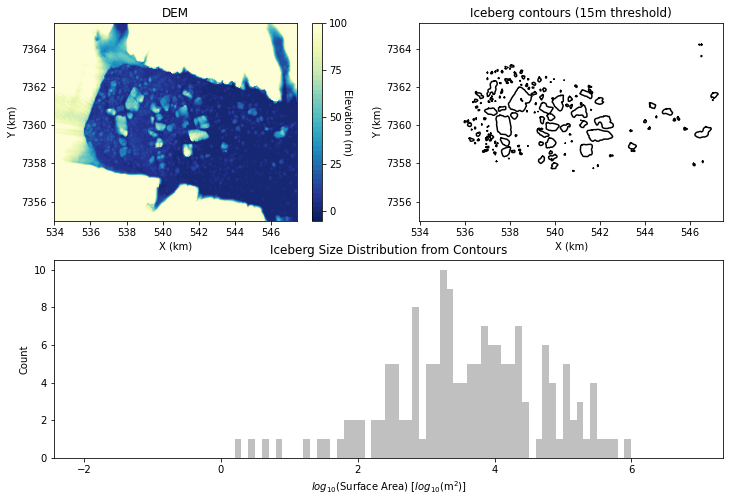

In [12]:
#Step 4: plot the three example threshold polygons
output_plot(x,y,elev,threshold,outlinePolygons,surface_areas)